# *Attention Mechanism*

seq2seq 모델은 <b>인코더</b>에서 입력 시퀀스를 <u>컨텍스트 벡터</u>라는 하나의 고정된 크기 벡터 표현으로 압축하고, <b>디코더</b>는 이 컨텍스트 벡터를 통해 출력 시퀀스를 만듦<br><br>
이러한 RNN에 기반한 seq2seq 모델에는 크게 두가지 문제가 존재<br>
1. 하나의 고정된 크기 벡터에 모든 정보를 압축하니 <u>정보 손실이 발생</u><br>
2. RNN의 고질적인 문제인 <b>기울기 소실(Vanashing Gradient)</b>가 발생<br>

이는 기계 번역 분야에서 입력 문장이 길어질수록 번역 품질이 떨어지는 현상이 발생하였음<br>
이에 대한 대안으로 등장한 기법이 <big><b>Attention</b></big><br><br>

### 어텐션 기본 아이디어
<blockquote>디코더에서 출력 단어를 예측하는 매 시점(time step)마다, 인코더에서 전체 입력 문장을 다시 한 번 참고<br>
단, 전체 입력 문장을 전부 다 동일한 비율로 참고하는 것이 아닌, 해당 시점에서 예측해야할 단어와 연관이 있는 입력 단어 부분을 좀 더 집중해서 보게 됨</blockquote>

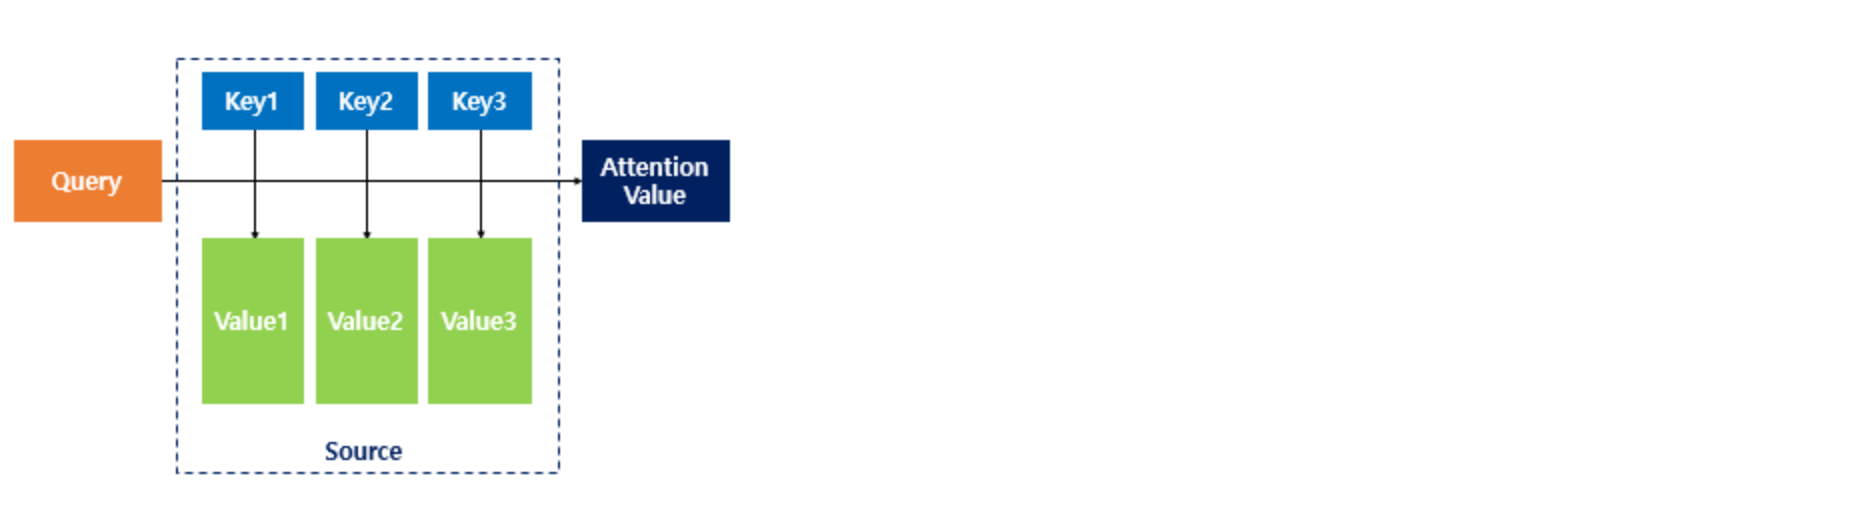
<b>Attention(Q, K, V) = Attention Value</b><br>
<blockquote><b>Q</b>(Query) : t 시점의 디코더 셀에서의 은닉 상태<br>
<b>K</b>(Keys) : 모든 시점의 인코더 셀의 은닉 상태들<br>
<b>V</b>(Values) : 모든 시점의 인코더 셀의 은닉 상태들</blockquote>
어텐션 함수는 주어진 <b>Query</b>에 대해 모든 <b>Key</b>와의 유사도를 각각 구함<br>
구한 유사도를 키와 맵핑되어있는 각각의 <b>Value</b>에 반영함<br>
그리고 유사도가 반영된 <b>Value</b>에 모두 더해 return

# *Dot-Product Attention*

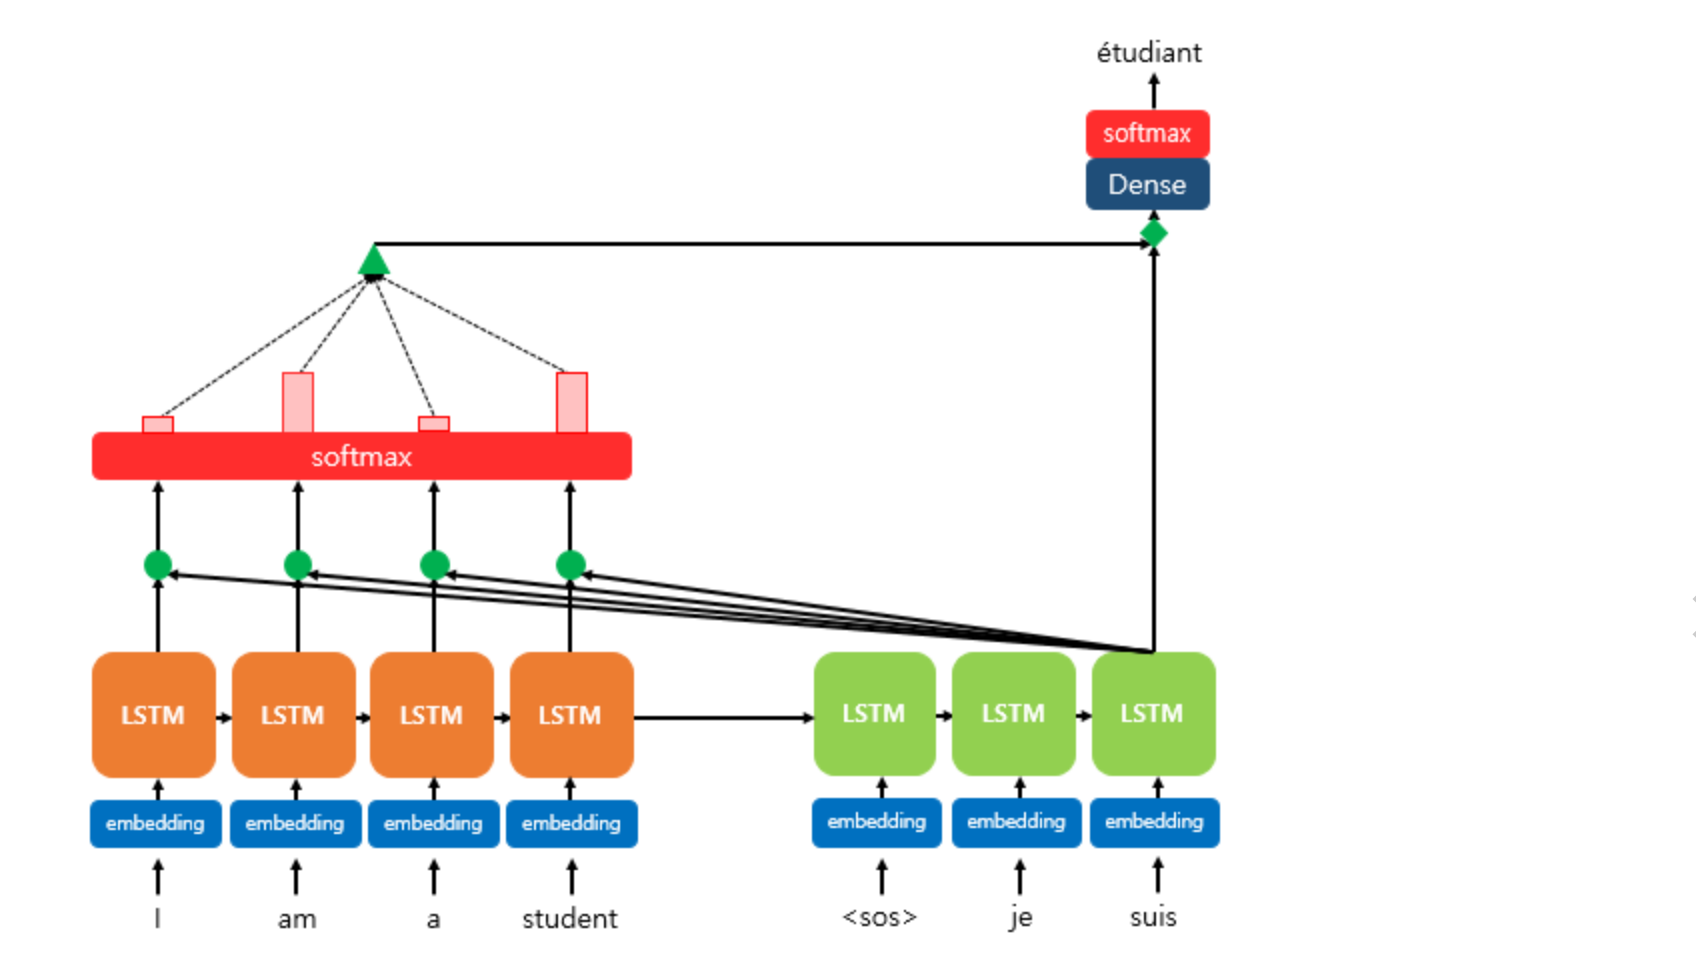

인코더 시점(time step)을 각각 1, 2, ..., N이라고 할 때, 인코더 은닉 상태(hidden state)를 각각 h1, h2, ..., hN라고 함<br>
디코더의 첫번째, 두번째 LSTM 셀은 이미 어텐션 메커니즘을 통해 je와 suis를 예측하는 과정을 거침<br>
디코더의 세번째 LSTM셀은 출력 단어를 예측하기 위해 인코더의 모든 입력 단어들의 정보를 다시 한번 참고함<br>

<big><b>소프트맥스</b></big> 함수를 통해 나온 결과값은 I, am, a, student 단어 각각이 출력 단어를 예측할 때 얼마나 도움이 되는지 정보를 수치화한 값<br>
소프트맥스 함수 위 빨간 직사각형 크기가 클 수록 도움이 되는 정도<br>
각 입력 단어가 디코더 예측이 도움 정도를 수치화하여 측정되면 이를 하나의 정보에 담아 디코더로 전송(초록색 삼각형)<br>

<b>1. 어텐션 스코어(Attention Score)를 구함</b><br>
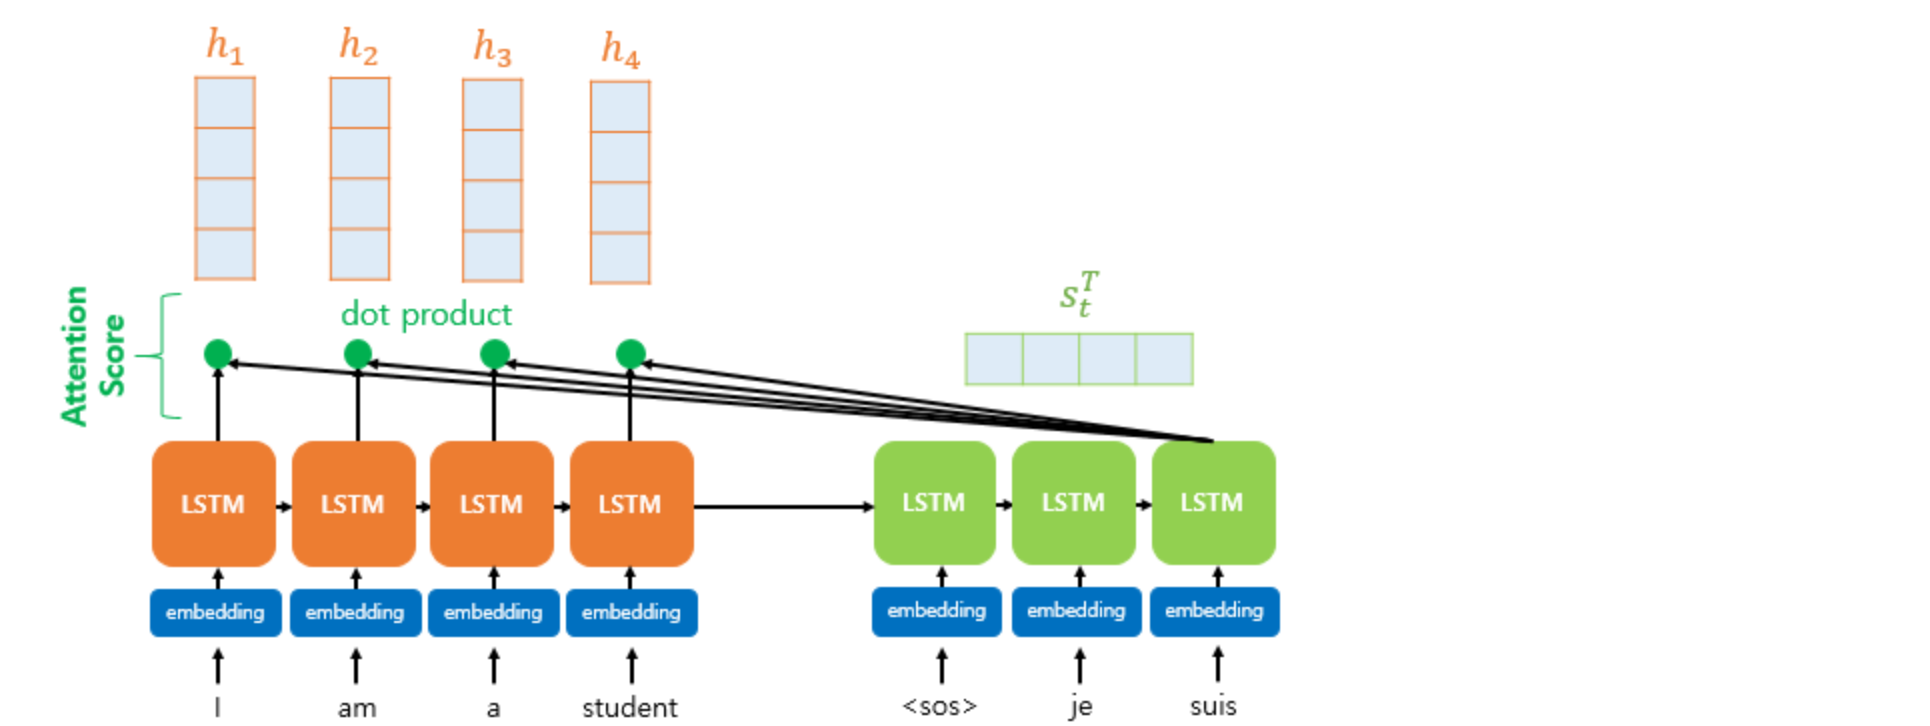

<b>2. 소프트맥스 함수를 통해 어텐션 분포(Attention Distribution)를 구함</b>
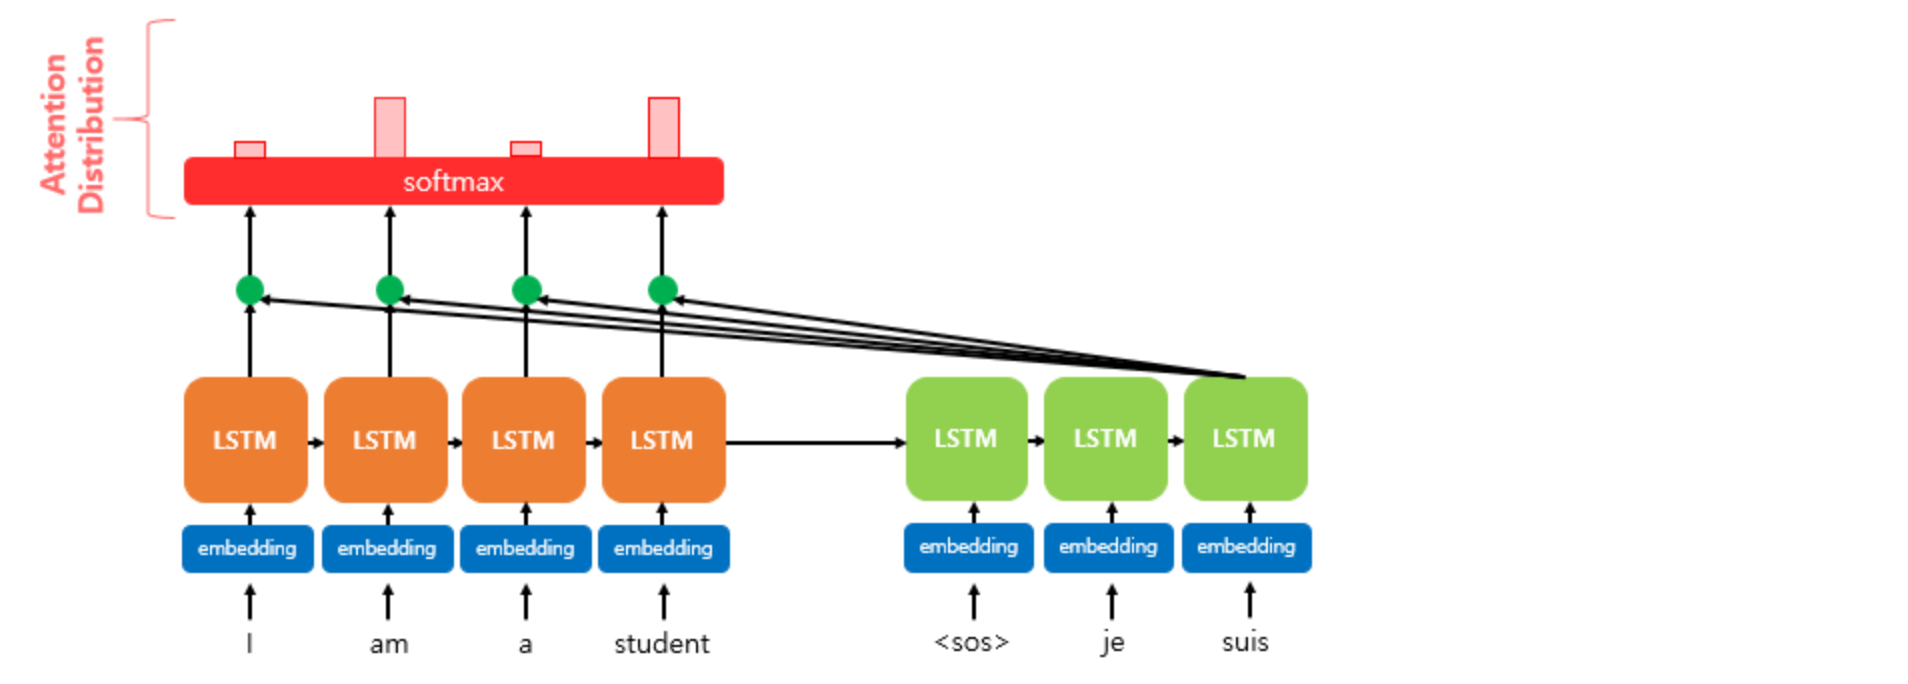

<b>3) 각 인코더의 어텐션 가중치와 은닉 상태를 가중합하여 어텐션 값(Attention Value, 컨텍스트 벡터)을 구한다</b>
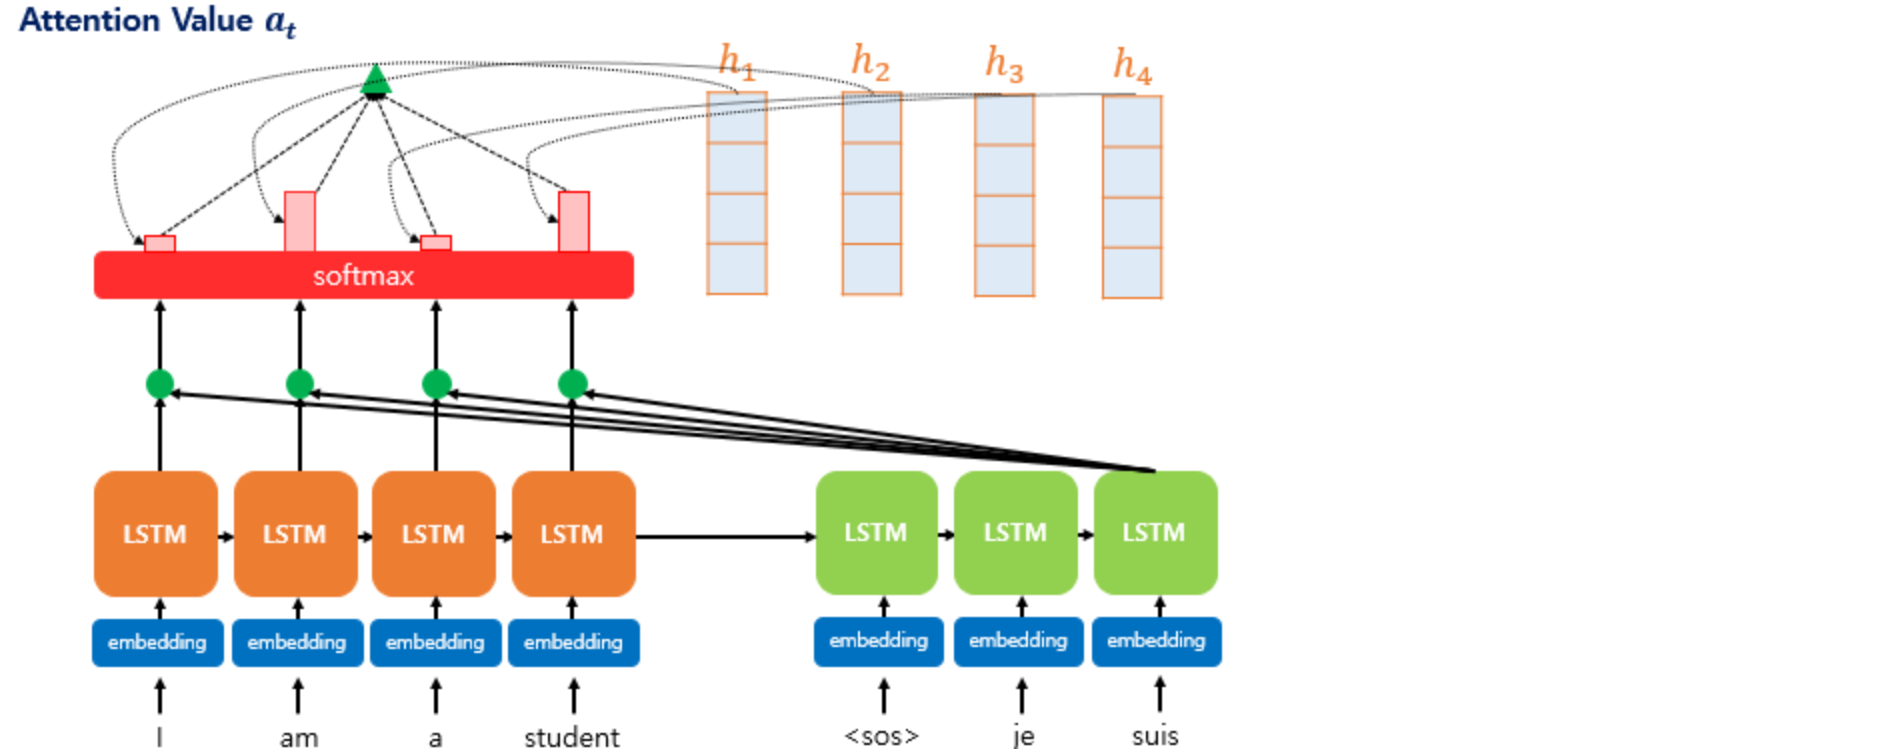

<b>4) 어텐션 값과 디코더의 t 시점의 은닉 상태를 연결한다.(Concatenate)</b>
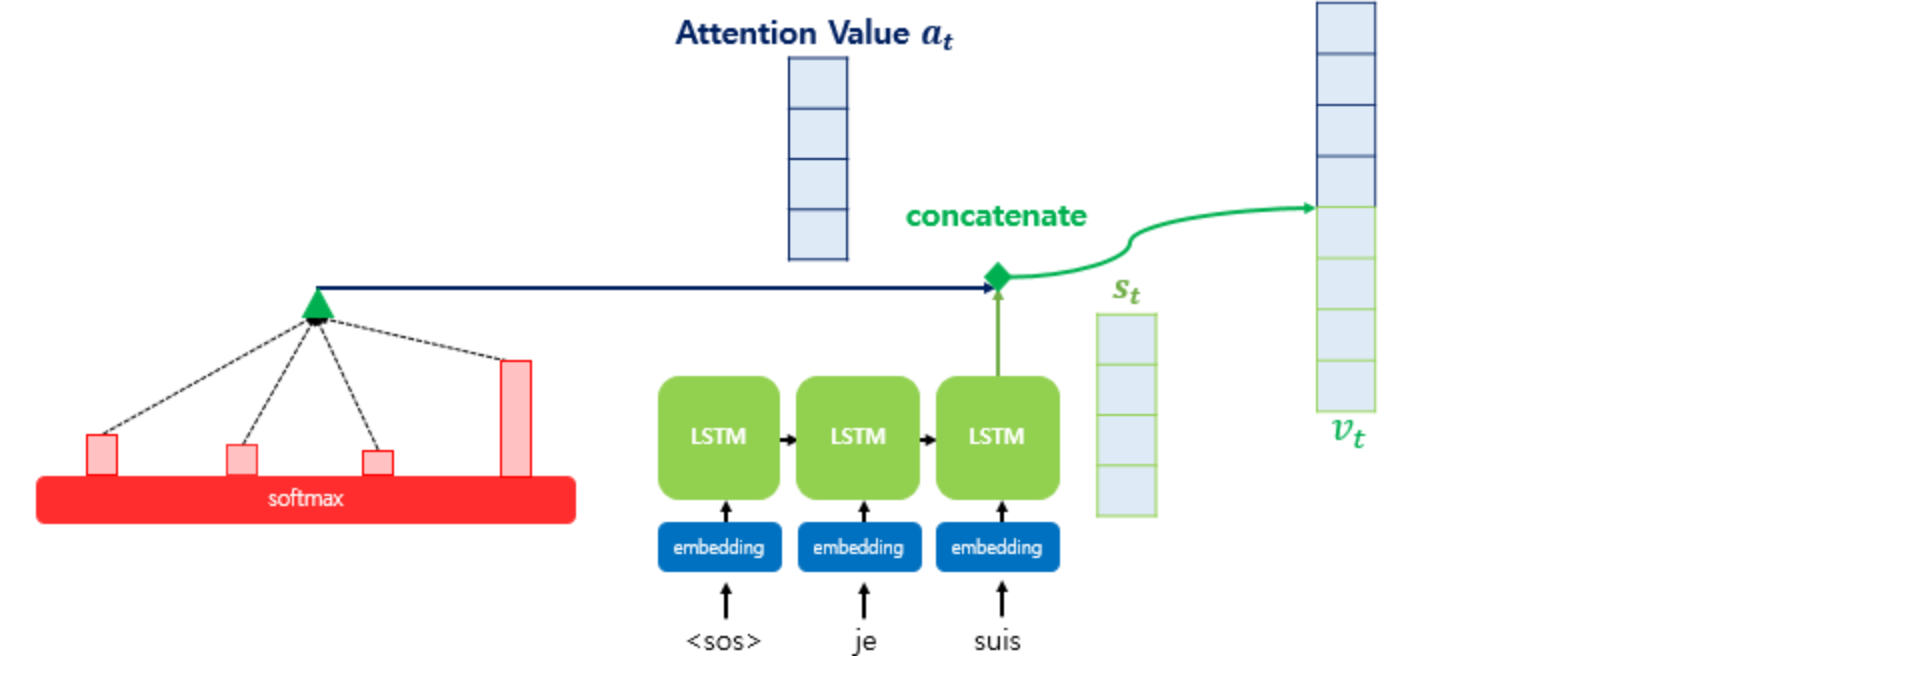

<b>5) 출력층 연산의 입력이 되는 ~st를 계산</b>
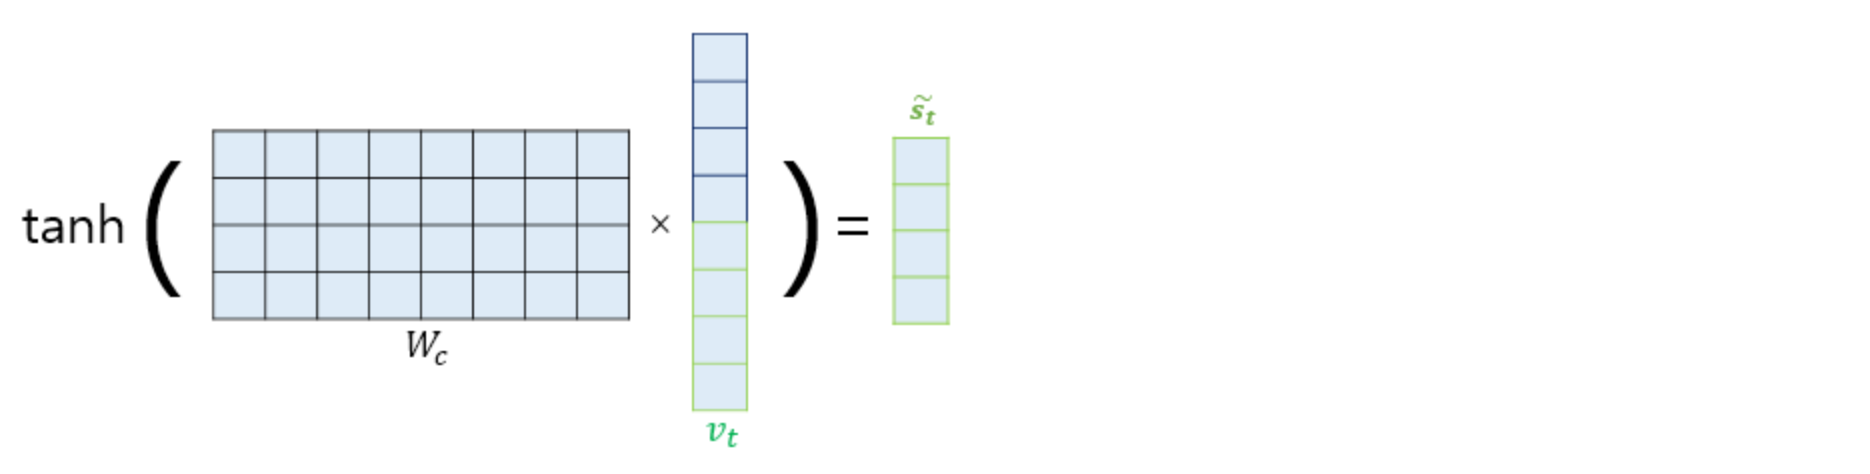
<br>가중치 행렬과 곱한 후에 하이퍼볼릭탄젠트 함수를 지나도록 하여 출력층 연산을 위한 새로운 벡터인 ~st를 얻음<br>
seq2seq의 출력층 입력이 t시점의 은닉 상태인 st였던 반면, 어텐션 메커니즘에서는 출력층의 입력이 ~st가 되는 셈<br>
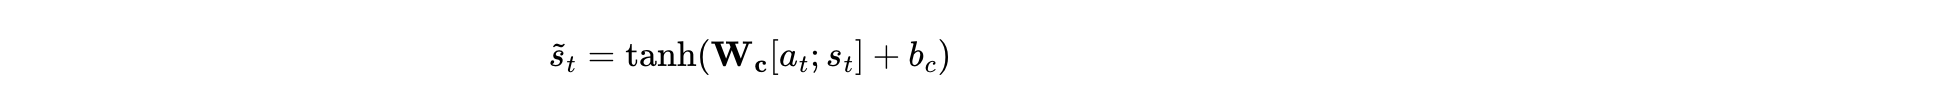
Wc는 학습 가능한 가중치 행렬, bc는 편향

<b>6) ~st를 출력층 입력으로 사용</b>
~st를 출력층의 입력으로 사용하여 예측 벡터를 얻음
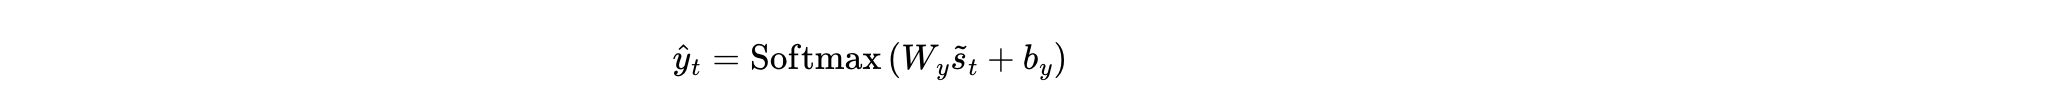

# 

# *Encoder*

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

In [3]:
class Encoder(nn.Module):
    def __init__(self, input_dim, emb_dim, enc_hid_dim, dec_hid_dim, dropout):
        suput().__init__()
        self.embedding = nn.Embedding(input_dim, emb_dim)
        
        # bidrectional=True 설정하여 bi-rnn 구현
        self.rnn = nn.GRU(emb_dim, enc_hid_dim, bidirectional=True)
        
        # 양방향 rnn 출력값을 concat 한 후 fc layer에 전달
        self.fc = nn.Linear(enc_hid_dim *2, dec_hid_dim)
        
        self.dropout = nn.Dropout(dropout)
    
    def forward(self, src):
        # 입력 x를 임베딩
        embedded = self.dropout(self.embedding(src))
        
        # rnn 출력값
        outputs, hidden = self.rnn(embedded)
        
        hidden = torch.tanh(self.fc(torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim = 1)))
        
        return outputs, hidden

# *Attention*

In [5]:
class Attention(nn.Module):
    def __init__(self, enc_hid_dim, dec_hid_dim):
        super().__init__()
        
        self.attn = nn.Linear((enc_hid_dim * 2) + dec_hid_dim, dec_hid_dim)
        self.v = nn.Linear(dec_hid_dim, 1, bias = False)
        
    def forward(self, hidden, encoder_outputs):
        batch_size = encoder_outputs.shape[1]
        src_len = encoder_outputs.shape[0]
        
        hidden = hidden.unsqueeze(1).repeat(1, src_len, 1)
        encoder_outputs = encoder_outputs.permute(1, 0, 2)
        energy = torch.tanh(self.attn(torch.cat((hidden, encoder_outputs), dim=2)))
        attention = self.v(energy).squeeze(2)
        
        return F.softmax(attention, dim=1)

# *Decoder*

In [6]:
class Decoder(nn.Module):
    def __init__(self, output_dim, emb_dim, enc_hid_dim, dec_hid_dim, dropout, attention):
        super().__init__()

        self.output_dim = output_dim
        self.attention = attention
        
        self.embedding = nn.Embedding(output_dim, emb_dim)
        
        # embedding과 weighted vector가 concat 된 후, 이전 hidden staet와 함께 입력
        self.rnn = nn.GRU((enc_hid_dim * 2) + emb_dim, dec_hid_dim)
        
        # 입력값 d(y_t), w_t, s_t
        self.fc_out = nn.Linear((enc_hid_dim * 2) + dec_hid_dim + emb_dim, output_dim)
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, input, hidden, encoder_outputs):
        input = input.unsqueeze(0)
        embedded = self.dropout(self.embedding(input))
        a = self.attention(hidden, encoder_outputs)
        a = a.unsqueeze(1)
        encoder_outputs = encoder_outputs.permute(1, 0, 2)

        weighted = torch.bmm(a, encoder_outputs)        
        weighted = weighted.permute(1, 0, 2)

        rnn_input = torch.cat((embedded, weighted), dim = 2)
            
        output, hidden = self.rnn(rnn_input, hidden.unsqueeze(0))
        
        assert (output == hidden).all()
        
        embedded = embedded.squeeze(0)
        output = output.squeeze(0)
        weighted = weighted.squeeze(0)
        
        prediction = self.fc_out(torch.cat((output, weighted, embedded), dim = 1))
        
        return prediction, hidden.squeeze(0)

# *Seq2Seq*

위에 정의한 Encoder, Decoder Class를 활용하여 Seq2Seq 정의

In [7]:
class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder, device):
        super().__init__()
        
        self.encoder = encoder
        self.decoder = decoder
        self.device = device
        
    def forward(self, src, trg, teacher_forcing_ratio = 0.5):
        
        batch_size = src.shape[1]
        trg_len = trg.shape[0]
        trg_vocab_size = self.decoder.output_dim
        
        #tensor to store decoder outputs
        outputs = torch.zeros(trg_len, batch_size, trg_vocab_size).to(self.device)
        
        #encoder_outputs is all hidden states of the input sequence, back and forwards
        #hidden is the final forward and backward hidden states, passed through a linear layer
        encoder_outputs, hidden = self.encoder(src)
                
        #first input to the decoder is the <sos> tokens
        input = trg[0,:]
        
        for t in range(1, trg_len):
            
            #insert input token embedding, previous hidden state and all encoder hidden states
            #receive output tensor (predictions) and new hidden state
            output, hidden = self.decoder(input, hidden, encoder_outputs)
            
            #place predictions in a tensor holding predictions for each token
            outputs[t] = output
            
            #decide if we are going to use teacher forcing or not
            teacher_force = random.random() < teacher_forcing_ratio
            
            #get the highest predicted token from our predictions
            top1 = output.argmax(1) 
            
            #if teacher forcing, use actual next token as next input
            #if not, use predicted token
            input = trg[t] if teacher_force else top1

        return outputs

# 

In [ ]:
import spacy
from torchtext.legacy.datasets import Multi30k
from torchtext.legacy.data import Field, BucketIterator

In [ ]:
spacy_de = spacy.load('de_core_news_sm')
spacy_en = spacy.load('en_core_web_sm')

In [10]:
def tokenize_de(text):
    """
    Tokenizes German text from a string into a list of strings
    """
    return [tok.text for tok in spacy_de.tokenizer(text)]

def tokenize_en(text):
    """
    Tokenizes English text from a string into a list of strings
    """
    return [tok.text for tok in spacy_en.tokenizer(text)]

In [ ]:
SRC = Field(tokenize = tokenize_de, 
            init_token = '<sos>', 
            eos_token = '<eos>', 
            lower = True)

TRG = Field(tokenize = tokenize_en, 
            init_token = '<sos>', 
            eos_token = '<eos>', 
            lower = True)

In [ ]:
INPUT_DIM = len(SRC.vocab)
OUTPUT_DIM = len(TRG.vocab)
ENC_EMB_DIM = 256
DEC_EMB_DIM = 256
ENC_HID_DIM = 512
DEC_HID_DIM = 512
ENC_DROPOUT = 0.5
DEC_DROPOUT = 0.5

attn = Attention(ENC_HID_DIM, DEC_HID_DIM)
enc = Encoder(INPUT_DIM, ENC_EMB_DIM, ENC_HID_DIM, DEC_HID_DIM, ENC_DROPOUT)
dec = Decoder(OUTPUT_DIM, DEC_EMB_DIM, ENC_HID_DIM, DEC_HID_DIM, DEC_DROPOUT, attn)

model = Seq2Seq(enc, dec, device).to(device)

# 

# *참고*
https://github.com/bentrevett/pytorch-seq2seq<br>
https://wikidocs.net/22893<br>
https://arxiv.org/abs/1409.0473